## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:

| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|j,t,m|i|
| Consumption|j,t,m,u|i|
| HH Characteristics|j,t,m|k|
| FCT|i,u|n|
| RDI|n|k|

where `j` indexes households, `t` indexes periods, `m` indexes
markets, `i` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



### Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc
!pip install oauth2client

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.7)


In [2]:
InputFiles = {'Expenditures':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','Expenditures'),
              'Consumption':('1RT5AfbZbWx-CmNaOHLp7aD9qEjgjiBv8lZmPexuKEWg','Consumption'), 
              'HH Characteristics':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','HH Characteristics'),
              'FCT':('1WabX6Gk2vlcM4RNQE-HlywRuf-zA5QMsXmZXHNPS4r8','FCT'),
              'FCT Codes':('1WabX6Gk2vlcM4RNQE-HlywRuf-zA5QMsXmZXHNPS4r8','FCT Food'),
             }

Note that the food items for the FCT for Uganda are **not** yet matched
up with food labels indexed by `i` in the expenditure and consumption datasets.



In [3]:
from eep153_tools import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,json_creds,sheet=None):

    df = read_sheets(key,json_creds,sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get purchased consumption quantities
q = get_clean_sheet(InputFiles['Consumption'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['FCT'][1])

fct.index.name = 'i'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [4]:
fct_codes = get_clean_sheet(InputFiles['FCT Codes'][0],
                      json_creds='../students-9093fa174318.json',
                        sheet=InputFiles['FCT Codes'][1])
#type(fct_codes['food_code'][0])
#food descriptions and food codes

In [5]:
z["Family Size"] = np.log(z["M 0-3"] + z["M 4-8"] + z["M 9-13"] + z["M 14-18"] + z["M 19-30"] + z["M 31-50"]+ z["M 51+"] + z["F 0-3"] + z["F 4-8"] + z["F 9-13"] + z["F 14-18"] + z["F 19-30"] + z["F 31-50"]+ z["F 51+"])
z = z.loc[np.isfinite(z['Family Size'])]

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
with_children_df  = pd.concat([z[z["M 0-3"] >0], z[z["M 4-8"] >0], z[z["M 9-13"] >0], z[z["M 14-18"] >0], z[z["F 0-3"] >0], z[z["F 4-8"] >0], z[z["F 9-13"] >0], z[z["F 14-18"] >0]]).drop_duplicates()
# Making a dataframe consisting of families that have children under 18
with_children_id = with_children_df.reset_index()["j"]
# Need to match these j's to the consumption j's to get the consumption for families with children

In [7]:
without_children_df = z.drop(with_children_df.index)
# Making a dataframe consisting of families without children
without_children_id = without_children_df.reset_index()["j"]
# Need to match j's to consumption j's for families without children



In [8]:
without_children_df

,,k,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000201,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
1013000204,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
1013000206,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
1013000209,2005,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000000
1021000103,2005,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010630003050502,2011,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
3010730012030203,2011,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1.098612
3010730016100203,2011,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.693147


### Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `result`.



In [9]:
import cfe

result = cfe.Result(y=np.log(x),z=z)

# Estimates most things (not counting std errors for betas).
xhat = result.get_predicted_expenditures() 

result.get_beta(as_df=True).sort_values(ascending=False) # Check sanity...

i
coffee                                0.651681
sweet bananas                         0.641347
oranges                               0.597327
passion fruits                        0.575809
fresh milk                            0.566944
bread                                 0.564532
mangoes                               0.512874
cooking oil                           0.479706
tomatoes                              0.473386
expenditure in restaurants on food    0.462714
dodo                                  0.455445
other vegetables                      0.448557
sugar                                 0.438035
onions                                0.433973
soda                                  0.418963
rice                                  0.417768
margarine,butter                      0.415750
eggs                                  0.412385
fresh fish                            0.409390
irish potatoes                        0.387566
beans fresh                           0.387504
beef       

### Step 3: Infer prices



Next, we divide predicted expenditures by actual quantities to get
prices, then choose prices corresponding to some units (e.g.,
kilograms) we can map into the  FCT.



In [10]:
xhatdf = xhat.to_dataframe('').unstack('i')
xhatdf.columns = xhatdf.columns.droplevel(0)

phat = (xhatdf/q).squeeze()

phat = phat.xs('Kilogram (kg)',level='u').groupby(['t','m']).median().dropna(how='all')
phat

,i,Matooke(cluster),Matooke(others),avocado,beans dry,beans fresh,beef,beer,bread,cabbages,carrots,...,simsim,soda,sorghum,sugar,sweet bananas,sweet potatoes dry,sweet potatoes fresh,tea,tomatoes,watermelon
t,m,,,,,,,,,,,,,,,,,,,,,
2005,1,NaN,NaN,NaN,1010.562240,1089.655498,2752.448432,NaN,1260.719691,NaN,NaN,...,NaN,NaN,NaN,1764.153433,NaN,NaN,NaN,801.378109,824.637182,NaN
2010,1,NaN,NaN,NaN,2200.764614,2101.270908,6069.728284,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3070.272770,NaN,NaN,NaN,1199.964146,808.096599,NaN
2011,1,NaN,NaN,NaN,2188.066765,2377.779811,7667.061788,NaN,3457.630932,NaN,NaN,...,NaN,NaN,NaN,3734.841232,2738.878416,NaN,NaN,1363.835986,1693.045473,NaN


In [11]:
q #Purchased consumption quantities

i                                            Matooke(cluster)  \
j            t    m u                                           
1.013000e+09 2005 1 Bottle (300 ml)                       NaN   
                    Bottle (500 ml)                       NaN   
                    Fish - Whole (1   2 kg)               NaN   
                    Kilogram (kg)                         NaN   
                    Litre                                 NaN   
...                                                       ...   
3.020000e+16 2011 1 Kilogram (kg)                         NaN   
                    Litre                                 NaN   
                    Packet (100 g)                        NaN   
                    Piece-Big                             NaN   
                    Piece-Small                           NaN   

i                                            Matooke(others)  avocado  \
j            t    m u                                                   
1.013000e+09 2005 1 Bottle (300 ml)                      NaN      NaN   
                    Bottle (500 ml)                      NaN      NaN   
                    Fish - Whole (1   2 kg)              NaN      NaN   
                    Kilogram (kg)                        NaN      NaN   
                    Litre                                NaN      NaN   
...                                                      ...      ...   
3.020000e+16 2011 1 Kilogram (kg)                        NaN      NaN   
                    Litre                                NaN      NaN   
                    Packet (100 g)                       NaN      NaN   
                    Piece-Big                            NaN      NaN   
                    Piece-Small                          NaN      NaN   

i                                            beans dry  beans fresh  beef  \
j            t    m u                                                       
1.013000e+09 2005 1 Bottle (300 ml)                NaN          NaN   NaN   
                    Bottle (500 ml)                NaN          NaN   NaN   
                    Fish - Whole (1   2 kg)        NaN          NaN   NaN   
                    Kilogram (kg)                  NaN          NaN   2.0   
                    Litre                          NaN          NaN   NaN   
...                                                ...          ...   ...   
3.020000e+16 2011 1 Kilogram (kg)                  NaN          NaN   NaN   
                    Litre                          NaN          NaN   NaN   
                    Packet (100 g)                 NaN          NaN   NaN   
                    Piece-Big                      NaN          NaN   NaN   
                    Piece-Small                    NaN          NaN   NaN   

i                                            beer  bread  cabbages  carrots  \
j            t    m u                                                         
1.013000e+09 2005 1 Bottle (300 ml)           NaN    NaN       NaN      NaN   
                    Bottle (500 ml)           2.0    NaN       NaN      NaN   
                    Fish - Whole (1   2 kg)   NaN    NaN       NaN      NaN   
                    Kilogram (kg)             NaN    NaN       NaN      NaN   
                    Litre                     NaN    NaN       NaN      NaN   
...                                           ...    ...       ...      ...   
3.020000e+16 2011 1 Kilogram (kg)             NaN    NaN       NaN      NaN   
                    Litre                     NaN    NaN       NaN      NaN   
                    Packet (100 g)            NaN    NaN       NaN      NaN   
                    Piece-Big                 NaN    NaN       NaN      NaN   
                    Piece-Small               NaN    NaN       NaN      NaN   

i                                            ...  simsim  soda  sorghum  \
j            t    m u                        ...                          
1.013000e+09 2005 1 Bott

In [12]:
# groups by protein, fruits, vegetables, carbs, etc

In [13]:
typeq = pd.read_csv("EEP153 Uganda FCT - Food Type.csv")
typeq

,food_descriptions,food_code,type
0,Matooke(cluster),5001.0,fruit
1,Matooke(others),5001.0,fruit
2,avocado,29110.0,vegetable
3,beans dry,6009.0,proteins
4,beans fresh,6002.0,proteins
...,...,...,...
57,sweet potatoes dry,3018.0,vegetable
58,sweet potatoes fresh,3001.0,vegetable
59,tea,NaN,drink
60,tomatoes,29063.0,vegetable


In [14]:
qd = typeq[["food_descriptions", "type "]]
qd = qd.set_index("food_descriptions")
qd

,type
food_descriptions,
Matooke(cluster),fruit
Matooke(others),fruit
avocado,vegetable
beans dry,proteins
beans fresh,proteins
...,...
sweet potatoes dry,vegetable
sweet potatoes fresh,vegetable
tea,drink


In [15]:
q

i                                            Matooke(cluster)  \
j            t    m u                                           
1.013000e+09 2005 1 Bottle (300 ml)                       NaN   
                    Bottle (500 ml)                       NaN   
                    Fish - Whole (1   2 kg)               NaN   
                    Kilogram (kg)                         NaN   
                    Litre                                 NaN   
...                                                       ...   
3.020000e+16 2011 1 Kilogram (kg)                         NaN   
                    Litre                                 NaN   
                    Packet (100 g)                        NaN   
                    Piece-Big                             NaN   
                    Piece-Small                           NaN   

i                                            Matooke(others)  avocado  \
j            t    m u                                                   
1.013000e+09 2005 1 Bottle (300 ml)                      NaN      NaN   
                    Bottle (500 ml)                      NaN      NaN   
                    Fish - Whole (1   2 kg)              NaN      NaN   
                    Kilogram (kg)                        NaN      NaN   
                    Litre                                NaN      NaN   
...                                                      ...      ...   
3.020000e+16 2011 1 Kilogram (kg)                        NaN      NaN   
                    Litre                                NaN      NaN   
                    Packet (100 g)                       NaN      NaN   
                    Piece-Big                            NaN      NaN   
                    Piece-Small                          NaN      NaN   

i                                            beans dry  beans fresh  beef  \
j            t    m u                                                       
1.013000e+09 2005 1 Bottle (300 ml)                NaN          NaN   NaN   
                    Bottle (500 ml)                NaN          NaN   NaN   
                    Fish - Whole (1   2 kg)        NaN          NaN   NaN   
                    Kilogram (kg)                  NaN          NaN   2.0   
                    Litre                          NaN          NaN   NaN   
...                                                ...          ...   ...   
3.020000e+16 2011 1 Kilogram (kg)                  NaN          NaN   NaN   
                    Litre                          NaN          NaN   NaN   
                    Packet (100 g)                 NaN          NaN   NaN   
                    Piece-Big                      NaN          NaN   NaN   
                    Piece-Small                    NaN          NaN   NaN   

i                                            beer  bread  cabbages  carrots  \
j            t    m u                                                         
1.013000e+09 2005 1 Bottle (300 ml)           NaN    NaN       NaN      NaN   
                    Bottle (500 ml)           2.0    NaN       NaN      NaN   
                    Fish - Whole (1   2 kg)   NaN    NaN       NaN      NaN   
                    Kilogram (kg)             NaN    NaN       NaN      NaN   
                    Litre                     NaN    NaN       NaN      NaN   
...                                           ...    ...       ...      ...   
3.020000e+16 2011 1 Kilogram (kg)             NaN    NaN       NaN      NaN   
                    Litre                     NaN    NaN       NaN      NaN   
                    Packet (100 g)            NaN    NaN       NaN      NaN   
                    Piece-Big                 NaN    NaN       NaN      NaN   
                    Piece-Small               NaN    NaN       NaN      NaN   

i                                            ...  simsim  soda  sorghum  \
j            t    m u                        ...                          
1.013000e+09 2005 1 Bott

In [16]:
for column in q.columns[1:]:
    df = typeq[typeq["food_descriptions"] == column]
    print(df)

  food_descriptions  food_code  type 
1   Matooke(others)     5001.0  fruit
  food_descriptions  food_code      type 
2           avocado    29110.0  vegetable
  food_descriptions  food_code     type 
3         beans dry     6009.0  proteins
  food_descriptions  food_code     type 
4       beans fresh     6002.0  proteins
  food_descriptions  food_code     type 
5              beef    11001.0  proteins
  food_descriptions  food_code  type 
6              beer    27281.0  drink
  food_descriptions  food_code  type 
7             bread     1305.0  carbs
  food_descriptions  food_code      type 
8          cabbages    29001.0  vegetable
  food_descriptions  food_code      type 
9           carrots    29011.0  vegetable
    food_descriptions  food_code  type 
10  cassava dry/flour     2020.0  carbs
   food_descriptions  food_code  type 
11     cassava fresh     2001.0  carbs
   food_descriptions  food_code     type 
12           chicken    13001.0  proteins
Empty DataFrame
Columns: [food_d

In [17]:
q["sum"] = q.sum(axis=1)

In [18]:
with_children_consumption = pd.merge(with_children_df.reset_index()[["j"]], q,  on= "j", how ="inner")

In [19]:
without_children_consumption = pd.merge(without_children_df.reset_index()[["j"]], q,  on= "j", how ="inner")

In [20]:
np.mean(with_children_consumption["sum"])

3.7603318863273625

In [21]:
np.mean(without_children_consumption["sum"])

3.0734332995904388

### Step 4: Predicting Positive Consumption



An issue with our assessment of fit is that we *predicted* that every
household would consume positive quantitites of every good, and in
making our assessment we ignored the (many) cases in which in fact the
household had zero expenditures on that good.  

Here we&rsquo;re going to go back and use similar framework to try and
estimate the probability with which we&rsquo;ll observe zero expenditures
as a function of &lambda;, prices, and household characteristics.



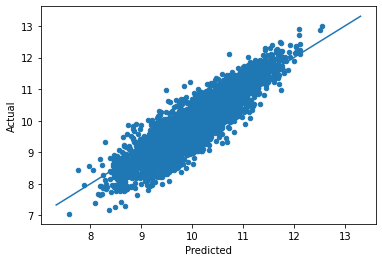

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

zeros_r = cfe.Result(y=(0.+(result.y>0)),z=result.z)
weights = zeros_r.get_predicted_log_expenditures()

# Truncate to make weights live in [0,1]
weights = weights.where((weights<1) + np.isnan(weights),1).where((weights>0) + np.isnan(weights),0)

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

# Calculate *expected* predicted expenditures, to make unconditional on being positive
xhat = (weights*result.get_predicted_expenditures())
xsum = xhat.sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xsum)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

### Step 5: Get predicted quantities



Now divide predicted expenditures by predicted prices to get predicted
quantities, and put back into a dataframe.



In [23]:
qhat = xhat/phat.to_xarray().to_array('i')

qhat = qhat.to_dataframe('q').unstack('i')

qhat.columns = qhat.columns.droplevel(0)

qhat

i                         beans dry  beans fresh      beef     bread  \
j                 t    m                                               
1013000201        2005 1   0.749357     0.126623  0.802436  0.646699   
                  2010 1   1.307575     0.159891  0.957931       NaN   
                  2011 1   0.724538     0.094169  0.430203  0.229113   
1013000202        2005 1        NaN          NaN       NaN       NaN   
                  2010 1        NaN          NaN       NaN       NaN   
...                             ...          ...       ...       ...   
3030230010040204  2010 1        NaN          NaN       NaN       NaN   
                  2011 1        NaN          NaN       NaN       NaN   
30211230006050302 2005 1        NaN          NaN       NaN       NaN   
                  2010 1        NaN          NaN       NaN       NaN   
                  2011 1        NaN          NaN       NaN       NaN   

i                         cabbages  cassava dry/flour  cassava fresh  chicken  \
j                 t    m                                                        
1013000201        2005 1       NaN           0.265049            NaN      NaN   
                  2010 1       NaN           1.222133            NaN      NaN   
                  2011 1       NaN           0.447821        0.85353      NaN   
1013000202        2005 1       NaN                NaN            NaN      NaN   
                  2010 1       NaN                NaN            NaN      NaN   
...                            ...                ...            ...      ...   
3030230010040204  2010 1       NaN                NaN            NaN      NaN   
                  2011 1       NaN                NaN            NaN      NaN   
30211230006050302 2005 1       NaN                NaN            NaN      NaN   
                  2010 1       NaN                NaN            NaN      NaN   
                  2011 1       NaN                NaN            NaN      NaN   

i                           coffee  cooking oil  ...  other vegetables  \
j                 t    m                         ...                     
1013000201        2005 1  0.173355          NaN  ...          0.434386   
                  2010 1       NaN          NaN  ...          0.457955   
                  2011 1       NaN          NaN  ...          0.075508   
1013000202        2005 1       NaN          NaN  ...               NaN   
                  2010 1       NaN          NaN  ...               NaN   
...                            ...          ...  ...               ...   
3030230010040204  2010 1       NaN          NaN  ...               NaN   
                  2011 1       NaN          NaN  ...               NaN   
30211230006050302 2005 1       NaN          NaN  ...               NaN   
                  2010 1       NaN          NaN  ...               NaN   
                  2011 1       NaN          NaN  ...               NaN   

i                         passion fruits      rice      salt  soda     sugar  \
j                 t    m                                                       
1013000201        2005 1        0.279511  0.633241  0.228451   NaN  1.141963   
                  2010 1        0.348891  1.142941  0.334021   NaN  1.444223   
                  2011 1        0.119051  0.462835  0.202192   NaN  0.639858   
1013000202        2005 1             NaN       NaN       NaN   NaN       NaN   
                  2010 1             NaN       NaN       NaN   NaN       NaN   
...                                  ...       ...       ...   ...       ...   
3030230010040204  2010 1             NaN       NaN       NaN   NaN       NaN   
                  2011 1             NaN       NaN       NaN   NaN       NaN   
30211230006050302 2005 1             NaN       NaN       NaN   NaN       NaN   
                  2010 1             NaN       NaN       NaN   NaN       NaN   
                  2011 1             NaN       NaN       NaN   NaN       NaN   

i    

In [24]:
qd.to_dict()["type "]

{'Matooke(cluster)': 'fruit',
 'Matooke(others)': 'fruit',
 'avocado': 'vegetable',
 'beans dry': 'proteins',
 'beans fresh': 'proteins',
 'beef': 'proteins',
 'beer': 'drink',
 'bread': 'carbs',
 'cabbages': 'vegetable',
 'carrots': 'vegetable',
 'cassava dry/flour': 'carbs',
 'cassava fresh': 'carbs',
 'chicken': 'proteins',
 'coffee': 'drink',
 'cooking oil': 'misc',
 'dodo': 'fruit',
 'dry/smoked fish': 'proteins',
 'egg plant': 'vegetable',
 'eggs': 'proteins',
 'expenditure in restaurants on food': 'type ',
 'fresh fish': 'proteins',
 'fresh milk': 'proteins',
 'ghee': 'misc',
 'goat meat': 'proteins',
 'green pepper': 'vegetable',
 'ground nuts in shell': 'proteins',
 'ground nuts paste': 'proteins',
 'ground nuts pounded': 'proteins',
 'ground nuts shelled': 'proteins',
 'irish potatoes': 'vegetable',
 'maize cobs': 'vegetable',
 'maize flour': 'carbs',
 'maize grains': 'carbs',
 'mangoes': 'fruit',
 'margarine, butter': 'misc',
 'matooke_1': 'fruit',
 'matooke_2': 'fruit',
 'm

In [25]:
types = qhat.T
types.rename(index = qd.to_dict()["type "]).groupby("i").sum()

j                1013000201                            1013000202              \
t                             2005      2010      2011              2005 2010   
m                                1         1         1                 1    1   
i                                                                               
carbs                     2.795451  4.165173  3.025593               0.0  0.0   
drink                     0.414606  0.199196  0.121464               0.0  0.0   
fruit                     0.328450  0.348891  0.171553               0.0  0.0   
fruits                    0.000000  0.000000  0.000000               0.0  0.0   
margarine,butter          0.025741  0.026876  0.018431               0.0  0.0   
misc                      1.370414  1.778244  0.842050               0.0  0.0   
proteins                  2.786127  3.583635  3.583031               0.0  0.0   
type                      0.000000  0.000000  0.000000               0.0  0.0   
vegetable                 1.642233  2.219758  0.751766               0.0  0.0   
vegetables                0.946969  0.987942  0.342632               0.0  0.0   

j                          1013000204                             \
t                     2011              2005      2010      2011   
m                        1                 1         1         1   
i                                                                  
carbs             2.331102               0.0  2.786514  2.492960   
drink             0.117398               0.0  0.160590  0.117501   
fruit             0.144107               0.0  0.210246  0.115050   
fruits            0.000000               0.0  0.000000  0.000000   
margarine,butter  0.016886               0.0  0.018986  0.015029   
misc              0.714864               0.0  1.405701  0.715740   
proteins          3.461638               0.0  2.546041  3.551434   
type              0.000000               0.0  0.000000  0.000000   
vegetable         0.678090               0.0  1.800985  0.647233   
vegetables        0.310650               0.0  0.664710  0.257821   

j                1013000206         ... 3010730016100203  3010830020020503   \
t                             2005  ...              2011              2005   
m                                1  ...                 1                 1   
i                                   ...                                       
carbs                          0.0  ...          1.618740               0.0   
drink                          0.0  ...          0.090102               0.0   
fruit                          0.0  ...          0.124879               0.0   
fruits                         0.0  ...          0.000000               0.0   
margarine,butter               0.0  ...          0.022666               0.0   
misc                           0.0  ...          0.500026               0.0   
proteins                       0.0  ...          2.770560               0.0   
type                           0.0  ...          0.000000               0.0   
vegetable                      0.0  ...          0.563685               0.0   
vegetables                     0.0  ...          0.243893               0.0   

j                               3030230010040204            30211230006050302  \
t                2010      2011              2005 2010 2011              2005   
m                   1         1                 1    1    1                 1   
i                                                                               
carbs             0.0  2.570948               0.0  0.0  0.0               0.0   
drink             0.0  0.136137               0.0  0.0  0.0               0.0   
fruit             0.0  0.217364               0.0  0.0  0.0               0.0   
fruits            0.0  0.000000               0.0  0.0  0.0               0.0   
margarine,butter  0.0  0.034191               0.0  0.0  0.0               0.0   
misc              0.0  0.817443               0.0  0.0  0.0               0.

### Step 6: Map predicted quantities into nutrients



May need some work to clean up the FCT, and create food names/indices
corresponding to the `i` index in `qhat`.



In [26]:
print(pd.Series(xhat.coords['i']).to_markdown())

|    | 0                                  |
|---:|:-----------------------------------|
|  0 | beans dry                          |
|  1 | beans fresh                        |
|  2 | beef                               |
|  3 | bread                              |
|  4 | cabbages                           |
|  5 | cassava dry/flour                  |
|  6 | cassava fresh                      |
|  7 | chicken                            |
|  8 | coffee                             |
|  9 | cooking oil                        |
| 10 | dodo                               |
| 11 | dry/smoked fish                    |
| 12 | eggs                               |
| 13 | expenditure in restaurants on food |
| 14 | fresh fish                         |
| 15 | fresh milk                         |
| 16 | goat meat                          |
| 17 | ground nuts pounded                |
| 18 | irish potatoes                     |
| 19 | maize cobs                         |
| 20 | maize flour              

In [27]:
fct_codes #Pasting here again for reference

,food_descriptions,food_code
0,Matooke(cluster),5001.0
1,Matooke(others),5001.0
2,avocado,29110.0
3,beans dry,6009.0
4,beans fresh,6002.0
...,...,...
57,sweet potatoes dry,3018.0
58,sweet potatoes fresh,3001.0
59,tea,NaN
60,tomatoes,29063.0


In [28]:
# Dictionary mapping index i to fct codes
i_to_fct = pd.read_csv('EEP153 Uganda FCT - Conversions.csv.csv').dropna().set_index('food_descriptions').squeeze().to_dict() #needs to be from uganda fct

i_to_fct = {k:int(v) for k,v in i_to_fct.items()}

# Create version of qhat with fct ids for labels
#myq = qhat.rename(columns=i_to_fct)[list(i_to_fct.values())]
myq = qhat.rename(columns=i_to_fct)
keep_columns = myq.columns.intersection(i_to_fct.values())
myq = myq[keep_columns]

# Drop goods with no obs, households with no goods
myq = myq.dropna(how='all',axis=1).dropna(how='all')

myfct=fct[fct['food_code'].isin(myq.columns)].drop(columns={'food_description', 'food_state', 'food_state_code',
                                                            'fct_source', 'fct_source_code', 'fct_source_descr',
                                                            'water_source_descr', 'retention_source', 'retention_source_code',
                                                            'retention_source_descr', 'food_group', 'food_group_code'})
# Create version of fct with just foods in myq
# Need to drop columns in fct that aren't nutrients
# Drop columns which aren't nutrients

FileNotFoundError: [Errno 2] No such file or directory: 'EEP153 Uganda FCT - Conversions.csv.csv'

In [ ]:
myfct

In [ ]:
myq

Before this will work, need columns of qhat to match columns of fct.



In [ ]:
nutrients = myq@myfct
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household.
# This part still needs fixing

### COMPARING FAMILY SIZE CONSUMPTION AND DEMAND VALUES

In [72]:
with_children_df  = pd.concat([z[z["M 0-3"] >0], z[z["M 4-8"] >0], z[z["M 9-13"] >0], z[z["M 14-18"] >0], z[z["F 0-3"] >0], z[z["F 4-8"] >0], z[z["F 9-13"] >0], z[z["F 14-18"] >0]]).drop_duplicates()
# Making a dataframe consisting of families that have children under 18
with_children_id = with_children_df.reset_index()["j"]
# Need to match these j's to the consumption j's to get the consumption for families with children

In [73]:
with_children_df


,,k,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000202,2005,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.693147
1013000210,2005,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1.386294
1013000213,2005,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1.098612
1021000113,2005,1,1,1,1,1,0,1,0,0,1,2,1,1,1,0,2.397895
1021000203,2005,1,1,1,1,1,0,0,1,0,0,0,0,2,0,1,2.079442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233002609,2011,1,0,0,0,0,1,1,0,0,0,0,1,0,0,2,1.609438
3183000309,2011,1,0,0,0,0,1,0,0,0,0,0,2,0,0,1,1.386294
4171000802,2011,1,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1.791759


In [74]:
without_children_df = z.drop(with_children_df.index)
# Making a dataframe consisting of families without children
without_children_id = without_children_df.reset_index()["j"]
# Need to match j's to consumption j's for families without children



### Calculating Consumption 

In [75]:
q["sum"] = q.sum(axis=1)

In [76]:
with_children_consumption = pd.merge(with_children_df.reset_index()[["j"]], q,  on= "j", how ="inner")

In [77]:
without_children_consumption = pd.merge(without_children_df.reset_index()[["j"]], q,  on= "j", how ="inner")

In [78]:
consumption = pd.DataFrame()

consumption["With Children Consumption"] = [np.mean(with_children_consumption["sum"])]
consumption["Without Children Consumption"] = np.mean(without_children_consumption["sum"])


consumption.rename_axis("consumption")


,With Children Consumption,Without Children Consumption
consumption,,
0,11.280996,9.2203


<AxesSubplot:>

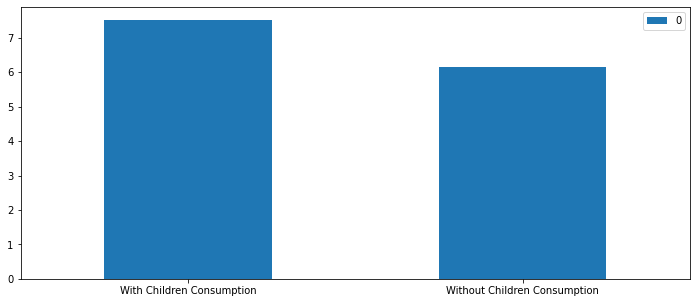

In [42]:
consumption.T.plot.bar(rot=0, figsize=(12,5))



### Calculating Consumption by Type of Food

In [43]:
typeq = pd.read_csv("EEP153 Uganda FCT - Food Type (1).csv")
typeq

,food_descriptions,food_code,type
0,Matooke(cluster),5001.0,fruit
1,Matooke(others),5001.0,fruit
2,avocado,29110.0,vegetable
3,beans dry,6009.0,proteins
4,beans fresh,6002.0,proteins
...,...,...,...
57,sweet potatoes dry,3018.0,vegetable
58,sweet potatoes fresh,3001.0,vegetable
59,tea,NaN,drink
60,tomatoes,29063.0,vegetable


In [44]:
qd = typeq[["food_descriptions", "type"]]
qd = qd.set_index("food_descriptions")


In [45]:
types = qhat.T
types = types.rename(index = qd.to_dict()["type"]).groupby("i").sum()

In [46]:
types = types.T

types["sum"] = types.sum(axis=1)

In [47]:
types = types.drop(columns ="margarine,butter")

In [48]:
with_children_foodgroup = pd.merge(with_children_df.reset_index()[["j"]], types,  on= "j", how ="inner")

In [49]:
without_children_foodgroup = pd.merge(without_children_df.reset_index()[["j"]], types,  on= "j", how ="inner")

In [50]:
without_children_foodgroup

,j,carbs,drink,fruit,misc,proteins,vegetable,sum
0,1013000201,2.795451,0.414606,0.328450,1.370414,2.786127,2.589203,10.309992
1,1013000201,4.165173,0.199196,0.348891,1.778244,3.583635,3.207701,13.309717
2,1013000201,3.025593,0.121464,0.171553,0.842050,3.583031,1.094398,8.856521
3,1013000201,2.795451,0.414606,0.328450,1.370414,2.786127,2.589203,10.309992
4,1013000201,4.165173,0.199196,0.348891,1.778244,3.583635,3.207701,13.309717
...,...,...,...,...,...,...,...,...
15388,3030230010040204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15389,3030230010040204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15390,30211230006050302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15391,30211230006050302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [51]:
one = pd.DataFrame(np.mean(with_children_foodgroup)).T

In [52]:
two = pd.DataFrame(np.mean(without_children_foodgroup)).T

In [53]:

one = one.drop(columns=["j"])



In [54]:
two = two.drop(columns=["j"])


In [55]:
food_group = one.append(two)


In [56]:
food_group["type"] = ["with children", "without children"]

In [57]:
food_group = food_group.set_index("type")

In [58]:
food_group = food_group.T

In [59]:
food_group["diff"] = food_group["with children"] - food_group["without children"]

In [60]:
food_group.sort_values("diff")

type,with children,without children,diff
fruit,0.108809,0.073157,0.035653
drink,0.103512,0.064574,0.038938
misc,0.680171,0.409870,0.270302
vegetable,0.929216,0.622382,0.306834
proteins,1.976774,1.258665,0.718109
carbs,1.929973,1.110682,0.819291
sum,5.739655,3.547291,2.192364


<AxesSubplot:>

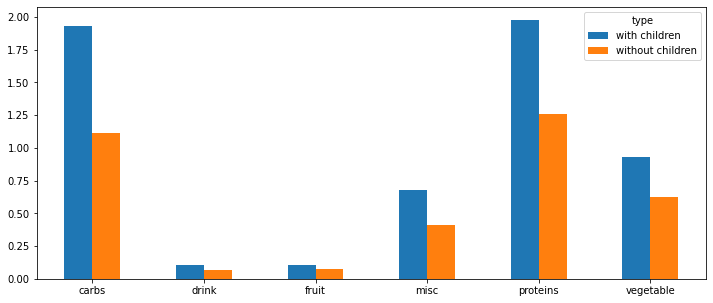

In [61]:
food_group[["with children", "without children"]].drop("sum", axis=0).plot.bar(rot=0, figsize=(12,5))


### calculate demand system

In [62]:
import cfe

result_one = cfe.Result(y=np.log(x),z=with_children_df)

# Estimates most things (not counting std errors for betas).
xhat_one = result.get_predicted_expenditures() 

result_one.get_beta(as_df=True).sort_values(ascending=False) # Check sanity...

i
coffee                                0.670841
passion fruits                        0.612178
bread                                 0.593853
sweet bananas                         0.591660
oranges                               0.587138
fresh milk                            0.545540
soda                                  0.502557
tomatoes                              0.494699
cooking oil                           0.490741
onions                                0.467732
fresh fish                            0.463081
expenditure in restaurants on food    0.461445
sugar                                 0.450001
other vegetables                      0.444225
eggs                                  0.421652
maize cobs                            0.420070
dodo                                  0.418673
beef                                  0.414548
irish potatoes                        0.405032
rice                                  0.404036
ground nuts pounded                   0.394690
dry/smoked 

In [63]:
import cfe

result_two = cfe.Result(y=np.log(x),z=without_children_df)

# Estimates most things (not counting std errors for betas).
xhat_two = result.get_predicted_expenditures() 

result_two.get_beta(as_df=True).sort_values(ascending=False) # Check sanity...



i
sweet bananas                         0.659237
fresh milk                            0.561520
passion fruits                        0.503741
dodo                                  0.478346
bread                                 0.477243
other vegetables                      0.477025
oranges                               0.473649
cooking oil                           0.463997
tomatoes                              0.428171
sugar                                 0.403305
rice                                  0.380704
matooke_1                             0.365141
onions                                0.358050
soda                                  0.345313
irish potatoes                        0.328392
fresh fish                            0.327420
maize flour                           0.319898
cabbages                              0.318818
eggs                                  0.315832
ground nuts pounded                   0.315217
beef                                  0.290611
dry/smoked 

In [64]:
with_children_demand = pd.DataFrame(result_one.get_beta(as_df=True).sort_values(ascending=False)).T

In [65]:
without_children_demand = pd.DataFrame(result_two.get_beta(as_df=True).sort_values(ascending=False)).T

In [66]:
demand= with_children_demand.append(without_children_demand)
demand

i,coffee,passion fruits,bread,sweet bananas,oranges,fresh milk,soda,tomatoes,cooking oil,onions,...,millet,maize flour,beans dry,sweet potatoes fresh,salt,cassava dry/flour,chicken,goat meat,mangoes,"margarine,butter"
beta,0.670841,0.612178,0.593853,0.591660,0.587138,0.54554,0.502557,0.494699,0.490741,0.467732,...,0.281905,0.272521,0.270854,0.228009,0.147429,0.059231,NaN,NaN,NaN,NaN
beta,NaN,0.503741,0.477243,0.659237,0.473649,0.56152,0.345313,0.428171,0.463997,0.358050,...,0.107193,0.319898,0.207363,0.209009,0.117204,NaN,NaN,NaN,NaN,NaN


In [67]:
demand["type"] = ["with children", "without children"]
demand = demand.set_index("type")

In [68]:
demand = demand.T

In [69]:
demand["diff"] = demand["with children"] - demand["without children"]



In [70]:
demand.sort_values("diff")

type,with children,without children,diff
i,,,
sweet bananas,0.591660,0.659237,-0.067577
dodo,0.418673,0.478346,-0.059672
maize flour,0.272521,0.319898,-0.047377
other vegetables,0.444225,0.477025,-0.032799
matooke_1,0.335607,0.365141,-0.029534
fresh milk,0.545540,0.561520,-0.015980
sweet potatoes fresh,0.228009,0.209009,0.018999
rice,0.404036,0.380704,0.023333
cooking oil,0.490741,0.463997,0.026744


<AxesSubplot:xlabel='i'>

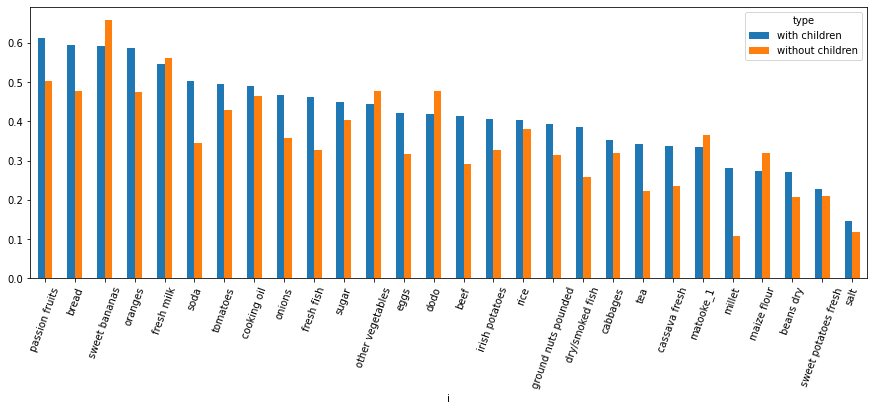

In [71]:
demand[["with children", "without children"]].dropna().plot.bar(rot=70, figsize=(15,5))
